This notebook uses Bokeh. It has been developped with Anaconda 3 with no other dependencies.

Bokeh seems to be a bit unstable with other libraries. So, if you have an error, try to update your conda but it may be neccesary to reinstall your anaconda... 

If this notebook does not work after an update, you still have access to the basic visualization notebook in the repository. We are sorry for the inconvenience.

In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
from time import sleep

from bokeh.plotting import figure 
from bokeh.io import output_notebook, show, curdoc
from bokeh.palettes import Category20
from bokeh.layouts import layout, widgetbox
from bokeh.models import ColumnDataSource, Div, HoverTool
from bokeh.models.widgets import Slider, DateSlider, MultiSelect, Toggle

output_notebook()

Loading BokehJS ...

# Loading data

In [2]:
from data.loader import get_kasios_obs, get_obs, map_path

In [3]:
df = get_obs(songs = False)
df['alpha'] = 1

birds_types = df.English_name.unique()
n_birds_types = len(birds_types)

In [4]:
df_test = get_kasios_obs(songs = False)
df_test["name"] = "Test bird n° " + df_test.index.astype(str)
df_test["color"] = "red"

# Birdmap

In [5]:
#
# Function to generate the dynamic map.
#
def bird_map(doc):
                
    #
    # Create Input controls
    #
    
    # Input for the date of observation.
    # The unit is days because the majority of observation have a specific days.
    input_date = DateSlider(title="Observation date", start=df['T'].min(), end=df['T'].max(),
                            value=df['T'].min(), step=1, format = "%B %Y")
    
    # Input for the window of observation
    # The map will show every points at +- T/2 days of the date of observation
    # This makes the assumption that a bird was at the spot before the observation
    # and will stay alo after the observation
    input_T = Slider(title="Observation window (days)", start=30, end=360,
                            value=180, step=1)
    
    # Input for the selection of specific species.
    input_bird_types = MultiSelect(title="Species", value=["All"],
                   options= ['All'] + list(birds_types) , size = n_birds_types + 1)
    
    # Animation inputs
    # When on the animation will jump by speed number of days every second
    input_speed = Slider(title="Animation speed (days/sec)", start=10, end=360,
                            value=180, step=1)
    # Button to launch the animation
    input_btn_anim = Toggle(label="Play", button_type="success")
    
    
    
    #
    # Function for callback
    #
    
    # Return the dataframe filtered by the different input
    def select_obs():        
        # Species filter
        bird_types = input_bird_types.value
        if "All" not in bird_types:
            selector_types = df['English_name'].isin(bird_types)
        else:
            selector_types = [True] * df.shape[0]

        # Date period filter
        T = input_T.value # window of observation
        obs_date = input_date.value # date of observation
        a = pd.Timestamp(obs_date - timedelta(days=T))
        b = pd.Timestamp(obs_date + timedelta(days=T))
        selector_date = ((a < df['T']) & (df['T'] < b))

        df_selected = df.loc[selector_date & selector_types].copy() # Selection
        
        # Updating the alpha to simulate life of a bird
        t = pd.to_datetime(input_date.value)
        a = (df_selected['T'] - t).dt.days.abs()
        a = 1 - 2*a/T
        a.loc[a < 0] = 0
        df_selected['alpha'] = a
        
        return df_selected
        
        

    # Update the source data
    # This will dynamically update the observations on the map
    def update():
        df_selected = select_obs()   
        
        source.data = dict(
            x=df_selected['X'],
            y=df_selected['Y'],
            color=df_selected["color"],
            alpha=df_selected["alpha"],
            name=df_selected["English_name"],
        )
    
    # This function handles the animation
    # It is called by repetition while the button is active
    # It basically add a $speed$ number of days every second
    def run_anim():
        FPS = 10
        
        # Parameters
        run_time_on = input_btn_anim.active # Button status
        speed = int(input_speed.value/FPS) # Number of days for the jump (5 FPS)
        
        # Dynamic button design
        input_btn_anim.button_type = "danger"  if (run_time_on) else "success" # Update color
        input_btn_anim.label = "Stop"  if (run_time_on) else "Play" # Update text
        
        # If animation activated
        if(run_time_on):
            a = input_date.value + timedelta(days=speed) # New date to show
            
            if pd.Timestamp(a) > pd.Timestamp(input_date.end):
                # If out of bound
                input_btn_anim.active = False #Stop the animation
                input_date.value = input_date.start #Go back to period start
            else:
                input_date.value = a #Change the date shown
                doc.add_timeout_callback(run_anim, 1000/FPS) # Callback in ms
    
            
    # Add callback for every input
    # Inputs that change the observation
    controls = [input_bird_types, input_date, input_T]
    for control in controls:
        control.on_change('value', lambda attr, old, new: update())
    # Specific callback for the animation
    input_btn_anim.on_change('active',lambda attr, old, new : run_anim())
    controls += [input_btn_anim, input_speed] # Inputs that do not change the observation
    
    
    
    
    #
    # Layout and window creation
    #
    
    
    # The DataSource shape for the map
    source = ColumnDataSource(data=dict(x=[], y=[], color=[], alpha=[], name = []))

    # Tools for the map
    TOOLS="crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

    # Figure for the map plot
    p = figure(title="Map with birds through time", tools = TOOLS, x_range=(0, 200), y_range=(0, 200))
    # Add the background image of the map
    p.image_url( url=[map_path],
             x=0, y=0, w=200, h=200, anchor="bottom_left")
    # Add point according to the data source
    p.circle(x="x", y="y", source=source, size=12, color="color", line_color=None, fill_alpha="alpha")
    
    # Add point according to the TEST data source
    source_test = ColumnDataSource(data=dict(x=df_test['X'], y=df_test['Y'], name = df_test['name'], color = df_test['color']))
    p.scatter(x="x", y="y", marker="x", size=15, color="color", source = source_test, legend="Test birds")
    
    # Location of the dumping site
    source_dumping = ColumnDataSource(data=dict(x=[148], y=[159], name=[""]))
    p.scatter(x="x", y="y", size=30, marker="circle_cross", fill_alpha=0.2, line_width=2, source=source_dumping, legend="Dumping site")
    
    # Custom hover tool
    # This will be shown when your cursor goes on an observation
    hover = HoverTool()
    hover.tooltips = [
        ("Bird type", "@name"),
        ("Position", "(@x, @y)"),
    ]
    p.tools.append(hover)

    # Window creation
    sizing_mode = 'fixed'
    inputs = widgetbox(*controls, sizing_mode=sizing_mode)
    l = layout([
        [inputs, p],
    ], sizing_mode=sizing_mode)

    # Load of the data and launching the window
    update()
    doc.add_root(l)

    
show(bird_map)

<div class="alert alert-info">
If we select the <b>Rose-creasted Blue Pipit</b>, and play the animation, we can clearly notice that the birds are <b>migrating</b> from the coordinates <b>(148, 159)</b> in <b>2014</b>, which is the location of the dumping site for the Kasios waste products.
</div>

# Kernel

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns; sns.set(color_codes=True)

In [7]:
df["year"] = df["T"].dt.year
# get the map image as an array so we can plot it 
map_img = mpimg.imread(map_path) 

/home/guillaume/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/guillaume/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/guillaume/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/guillaume/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a biv

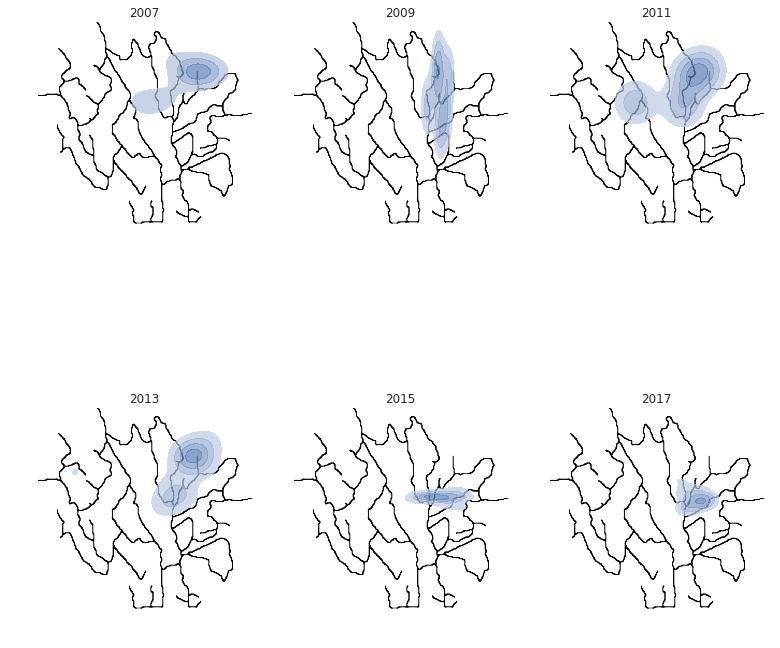

In [10]:
f = plt.figure(figsize=(13, 13))
f.tight_layout()
for i, year in enumerate(range(2007, 2018, 2)):
    a = df.loc[(df.year == year) & (df["English_name"] == "Rose-crested Blue Pipit")]

    ax = f.add_subplot(2, 3, 1+i, aspect='equal')
    ax = sns.kdeplot(a[["X", "Y"]], shade=True, shade_lowest=False, alpha = 0.7, n_levels = 4)
    ax.set_xlim(0, 200)
    ax.set_ylim(0,200)
    ax.grid(False)
    plt.axis('off')
    plt.title(year)

    ax.imshow(map_img,
              aspect = ax.get_aspect(),
              extent = ax.get_xlim() + ax.get_ylim(),
              zorder = 0) # put the map under the heatmap

<div class="alert alert-info"r>
Here also, we clearly see the <b> migration of the Rose-creasted Blue Pipit</b>.
</div>